# Modèles PyTorch - Classification et Régression

Ce notebook implémente deux modèles simples avec PyTorch:
1. **Classification**: Prédire si un étudiant va compléter le cours (Completed: 0 ou 1)
2. **Régression**: Prédire Quiz_Score_Avg, Project_Grade, Satisfaction_Rating, Time_Spent_Hours

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Vérifier si GPU disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé: {device}")

Device utilisé: cpu


## 1. Chargement des données

In [11]:
# Classification
X_class = pd.read_csv('../data/processed/X_classification.csv')
y_class = pd.read_csv('../data/processed/y_classification.csv')

# Régression
X_reg = pd.read_csv('../data/processed/X_regression.csv')
y_reg = pd.read_csv('../data/processed/y_regression.csv')

print("CLASSIFICATION:")
print(f"X_class: {X_class.shape}")
print(f"y_class: {y_class.shape}")

print("\nREGRESSION:")
print(f"X_reg: {X_reg.shape}")
print(f"y_reg: {y_reg.shape}")

CLASSIFICATION:
X_class: (56172, 42)
y_class: (56172, 1)

REGRESSION:
X_reg: (56172, 37)
y_reg: (56172, 4)


---
# PARTIE 1: MODELE DE CLASSIFICATION
---

**Objectif**: Prédire si un étudiant va compléter le cours (0 ou 1)

In [12]:
# Préparation des données - Classification
X_class_np = X_class.values
y_class_np = y_class.values.ravel()

# 1. Train (70%) / Test (30%)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class_np, y_class_np, test_size=0.30, random_state=42)

# 2. test (15%) / val (15%) 
X_test_class, X_val_class, y_test_class, y_val_class = train_test_split(X_train_class, y_train_class, test_size=0.5, random_state=42)

X_train_class_tensor = torch.FloatTensor(X_train_class).to(device)
X_val_class_tensor = torch.FloatTensor(X_val_class).to(device)
X_test_class_tensor = torch.FloatTensor(X_test_class).to(device)
y_train_class_tensor = torch.FloatTensor(y_train_class).to(device)
y_val_class_tensor = torch.FloatTensor(y_val_class).to(device)
y_test_class_tensor = torch.FloatTensor(y_test_class).to(device)

print(f"Données Classification: Train={X_train_class_tensor.shape[0]}, Val={X_val_class_tensor.shape[0]}, Test={X_test_class_tensor.shape[0]}")

Données Classification: Train=39320, Val=19660, Test=19660


In [13]:
# Modèle de Classification
class CourseCompletionClassifier(nn.Module):
    def __init__(self, input_dim):
        super(CourseCompletionClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256), 
            nn.BatchNorm1d(256), 
            nn.ReLU(), 
            nn.Dropout(0.3),

            nn.Linear(256, 128),        
            nn.BatchNorm1d(128),  
            nn.ReLU(), 
            nn.Dropout(0.3),

            nn.Linear(128, 64),         
            nn.BatchNorm1d(64),  
            nn.ReLU(), 
            nn.Dropout(0.2),

            nn.Linear(64, 32),         
            nn.BatchNorm1d(32),  
            nn.ReLU(), 
            nn.Dropout(0.1),

            nn.Linear(32, 1),          
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model_class = CourseCompletionClassifier(X_train_class_tensor.shape[1]).to(device)

In [14]:
# Entraînement Classification avec Early Stopping
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_class.parameters(), lr=0.01)

best_val_loss = float('inf')
patience = 40
counter = 0
train_history, val_history = [], []

for epoch in range(500):
    model_class.train()
    optimizer.zero_grad()
    output = model_class(X_train_class_tensor)
    loss = criterion(output.squeeze(), y_train_class_tensor)
    loss.backward()
    optimizer.step()
    
    # Validation step
    model_class.eval()
    with torch.no_grad():
        val_out = model_class(X_val_class_tensor)
        val_loss = criterion(val_out.squeeze(), y_val_class_tensor)
    
    train_history.append(loss.item())
    val_history.append(val_loss.item())
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
            
    if (epoch+1) % 20 == 0: 
        print(f"Epoch {epoch+1:03d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

# Sauvegarde du meilleur modèle
torch.save(model_class.state_dict(), '../models/torch_clf_model.pth')

Epoch 020 | Train Loss: 0.6547 | Val Loss: 0.6609
Epoch 040 | Train Loss: 0.6465 | Val Loss: 0.6430
Epoch 060 | Train Loss: 0.6382 | Val Loss: 0.6287
Epoch 080 | Train Loss: 0.6273 | Val Loss: 0.6079
Epoch 100 | Train Loss: 0.6125 | Val Loss: 0.5828
Epoch 120 | Train Loss: 0.5988 | Val Loss: 0.5542
Epoch 140 | Train Loss: 0.5853 | Val Loss: 0.5212
Epoch 160 | Train Loss: 0.5739 | Val Loss: 0.4947
Epoch 180 | Train Loss: 0.5599 | Val Loss: 0.4664
Epoch 200 | Train Loss: 0.5490 | Val Loss: 0.4501
Epoch 220 | Train Loss: 0.5408 | Val Loss: 0.4295
Epoch 240 | Train Loss: 0.5326 | Val Loss: 0.4229
Epoch 260 | Train Loss: 0.5271 | Val Loss: 0.4097
Epoch 280 | Train Loss: 0.5218 | Val Loss: 0.3952
Epoch 300 | Train Loss: 0.5146 | Val Loss: 0.3885
Epoch 320 | Train Loss: 0.5100 | Val Loss: 0.3809
Epoch 340 | Train Loss: 0.5105 | Val Loss: 0.3773
Epoch 360 | Train Loss: 0.5042 | Val Loss: 0.3628
Epoch 380 | Train Loss: 0.5016 | Val Loss: 0.3556
Epoch 400 | Train Loss: 0.4969 | Val Loss: 0.3504


Accuracy sur le test set: 0.8951 (89.51%)


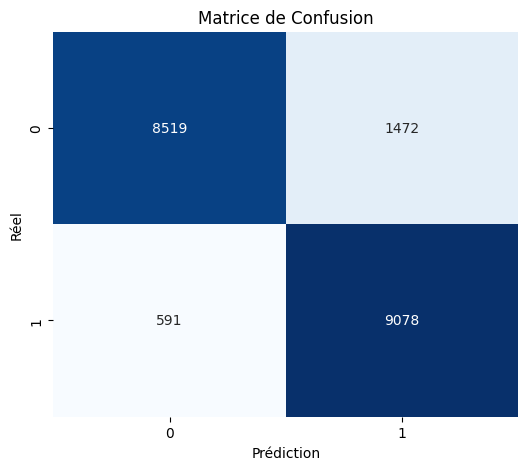


Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.85      0.89      9991
         1.0       0.86      0.94      0.90      9669

    accuracy                           0.90     19660
   macro avg       0.90      0.90      0.89     19660
weighted avg       0.90      0.90      0.89     19660



In [15]:
# EVALUATION - CLASSIFICATION
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

model_class.eval()
with torch.no_grad():
    y_pred_test = model_class(X_test_class_tensor)
    y_pred_classes = (y_pred_test.squeeze() > 0.5).float()

y_pred_np = y_pred_classes.cpu().numpy()
y_test_np = y_test_class_tensor.cpu().numpy()

# Accuracy
accuracy = accuracy_score(y_test_np, y_pred_np)
print(f"Accuracy sur le test set: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred_np)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de Confusion')
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.show()

# Detailed Report
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_np))

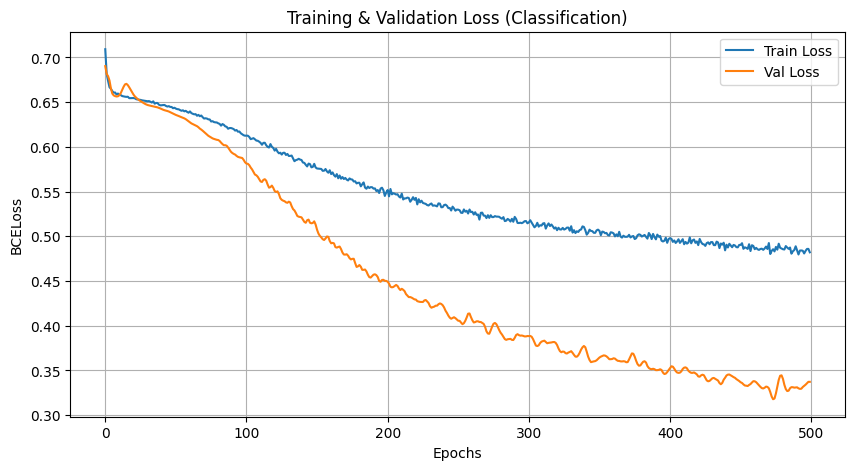

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(train_history, label='Train Loss')
plt.plot(val_history, label='Val Loss')
plt.title('Training & Validation Loss (Classification)')
plt.xlabel('Epochs')
plt.ylabel('BCELoss')
plt.legend()
plt.grid(True)
plt.show()

---
# PARTIE 2: MODELE DE REGRESSION
---

**Objectif**: Prédire 4 variables continues:
- Quiz_Score_Avg
- Project_Grade  
- Satisfaction_Rating
- Time_Spent_Hours

In [21]:
# Préparation des données - Régression
X_reg_np = X_reg.values
y_reg_np = y_reg.values

# 1. Train (70%) / Test (30%)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg_np, y_reg_np, test_size=0.30, random_state=42)

# 2. test (15%) / val (15%) 
X_test_reg, X_val_reg, y_test_reg, y_val_reg = train_test_split(X_train_reg, y_train_reg, test_size=0.5, random_state=42)

#scalarisation de y
scaler_y = StandardScaler()
y_train_reg = scaler_y.fit_transform(y_train_reg)
y_val_reg = scaler_y.transform(y_val_reg)
y_test_reg = scaler_y.transform(y_test_reg)

# To Tensor
X_train_reg = torch.FloatTensor(X_train_reg).to(device)
X_val_reg = torch.FloatTensor(X_val_reg).to(device)
X_test_reg = torch.FloatTensor(X_test_reg).to(device)
y_train_reg = torch.FloatTensor(y_train_reg).to(device)
y_val_reg = torch.FloatTensor(y_val_reg).to(device)
y_test_reg = torch.FloatTensor(y_test_reg).to(device)

print(f"Données Classification: Train={X_train_reg.shape[0]}, Val={X_val_reg.shape[0]}, Test={X_test_reg.shape[0]}")

Données Classification: Train=39320, Val=19660, Test=19660


In [22]:
# Modèle de Régression Amélioré
class StudentPerformanceRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(StudentPerformanceRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256), 
            nn.BatchNorm1d(256), 
            nn.ReLU(), 
            nn.Dropout(0.2),

            nn.Linear(256, 128),       
            nn.BatchNorm1d(128), 
            nn.ReLU(), 
            nn.Dropout(0.2),

            nn.Linear(128, 64),        
            nn.BatchNorm1d(64),  
            nn.ReLU(), 
            nn.Dropout(0.1),

            nn.Linear(64, 32),         
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.net(x)

model_reg = StudentPerformanceRegressor(X_train_reg.shape[1], y_train_reg.shape[1]).to(device)

In [27]:
# Entraînement Régression avec Early Stopping
criterion_reg = nn.HuberLoss(delta=1.0)
optimizer_reg = torch.optim.Adam(model_reg.parameters(), lr=0.02)

best_reg_loss = float('inf')
patience_reg = 40
counter_reg = 0
r_train_hist, r_val_hist = [], []

for epoch in range(500):
    model_reg.train()
    optimizer_reg.zero_grad()
    pred = model_reg(X_train_reg)
    loss = criterion_reg(pred, y_train_reg)
    loss.backward()
    optimizer_reg.step()
    
    model_reg.eval()
    with torch.no_grad():
        val_pred = model_reg(X_val_reg)
        val_loss = criterion_reg(val_pred, y_val_reg)
    
    r_train_hist.append(loss.item())
    r_val_hist.append(val_loss.item())

    if val_loss < best_reg_loss:
        best_reg_loss = val_loss
        counter_reg = 0
    else:
        counter_reg += 1
        if counter_reg >= patience_reg:
            print(f"Early stopping at epoch {epoch+1}")
            break
            
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1:03d} | Train HuberLoss: {loss.item():.4f} | Val HuberLoss: {val_loss.item():.4f}")

# Sauvegarde du meilleur modèle
torch.save(model_class.state_dict(), '../models/torch_reg_model.pth')

Epoch 020 | Train HuberLoss: 0.3807 | Val HuberLoss: 0.3608
Epoch 040 | Train HuberLoss: 0.3193 | Val HuberLoss: 0.3028
Epoch 060 | Train HuberLoss: 0.2907 | Val HuberLoss: 0.2685
Epoch 080 | Train HuberLoss: 0.2814 | Val HuberLoss: 0.2558
Epoch 100 | Train HuberLoss: 0.2753 | Val HuberLoss: 0.2425
Epoch 120 | Train HuberLoss: 0.2725 | Val HuberLoss: 0.2395
Epoch 140 | Train HuberLoss: 0.2693 | Val HuberLoss: 0.2336
Epoch 160 | Train HuberLoss: 0.2690 | Val HuberLoss: 0.2323
Epoch 180 | Train HuberLoss: 0.2661 | Val HuberLoss: 0.2287
Epoch 200 | Train HuberLoss: 0.2652 | Val HuberLoss: 0.2275
Epoch 220 | Train HuberLoss: 0.2646 | Val HuberLoss: 0.2252
Epoch 240 | Train HuberLoss: 0.2647 | Val HuberLoss: 0.2228
Epoch 260 | Train HuberLoss: 0.2633 | Val HuberLoss: 0.2266
Epoch 280 | Train HuberLoss: 0.2630 | Val HuberLoss: 0.2208
Epoch 300 | Train HuberLoss: 0.2603 | Val HuberLoss: 0.2190
Epoch 320 | Train HuberLoss: 0.2598 | Val HuberLoss: 0.2275
Epoch 340 | Train HuberLoss: 0.2600 | Va

In [28]:
# Évaluation Régression
model_reg.eval()
with torch.no_grad():
    y_pred_scaled = model_reg(X_test_reg).cpu().numpy()
    y_test_scaled = y_test_reg.cpu().numpy()

# Inverse transform
y_pred_final = scaler_y.inverse_transform(y_pred_scaled)
y_test_final = scaler_y.inverse_transform(y_test_scaled)

target_names = ["Quiz_Score_Avg", "Project_Grade", "Satisfaction_Rating", "Time_Spent_Hours"]
for i, col in enumerate(target_names):
    rmse = np.sqrt(mean_squared_error(y_test_final[:, i], y_pred_final[:, i]))
    r2 = r2_score(y_test_final[:, i], y_pred_final[:, i])
    print(f"{col:15} | RMSE: {rmse:.3f} | R2: {r2:.3f}")


Quiz_Score_Avg  | RMSE: 10.095 | R2: 0.347
Project_Grade   | RMSE: 3.939 | R2: 0.934
Satisfaction_Rating | RMSE: 0.551 | R2: 0.381
Time_Spent_Hours | RMSE: 3.053 | R2: 0.342


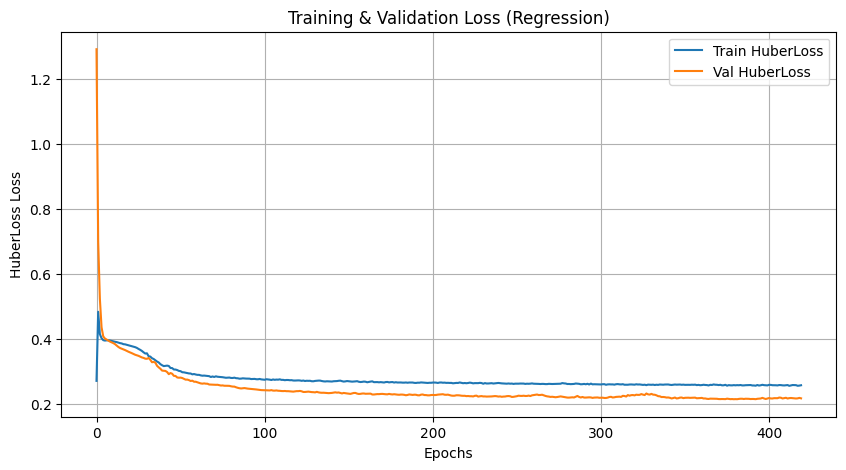

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(r_train_hist, label='Train HuberLoss')
plt.plot(r_val_hist, label='Val HuberLoss')
plt.title('Training & Validation Loss (Regression)')
plt.xlabel('Epochs')
plt.ylabel('HuberLoss Loss')
plt.legend()
plt.grid(True)
plt.show()

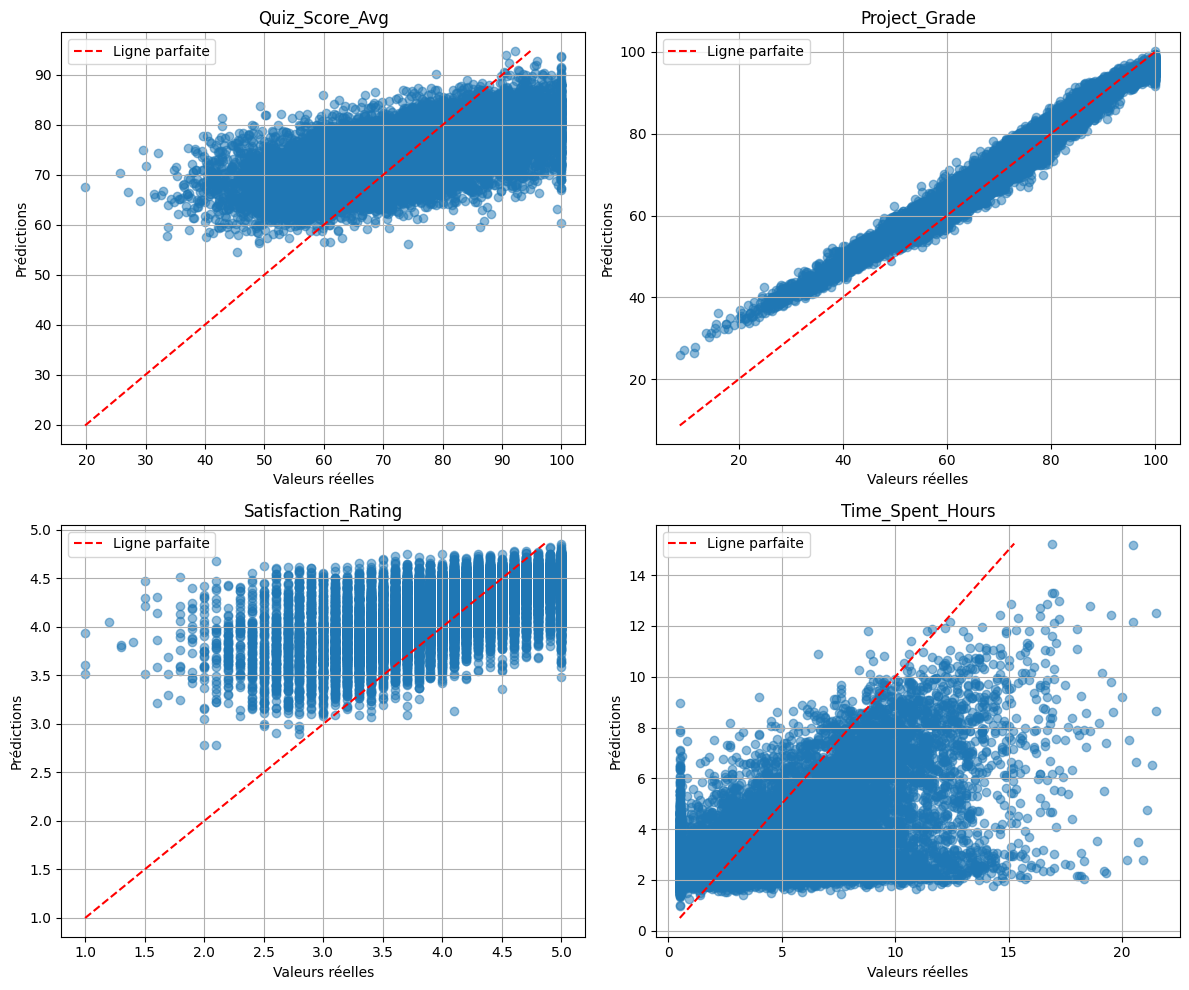

In [30]:
# VISUALISATION - PREDICTIONS vs VALEURS REELLES

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
for i, (ax, name) in enumerate(zip(axes, target_names)):
    ax.scatter(y_test_final[:, i], y_pred_final[:, i], alpha=0.5)
    ax.plot([y_test_final[:, i].min(), y_pred_final[:, i].max()],
            [y_test_final[:, i].min(), y_pred_final[:, i].max()],
            'r--', label='Ligne parfaite')
    ax.set_xlabel('Valeurs réelles')
    ax.set_ylabel('Prédictions')
    ax.set_title(f'{name}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()